In [1]:
import os
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib.patches import Ellipse
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Data Loading and Exploration
def load_data(file_path, digits=['digit_1','digit_2','digit_3']):
    """Load rotated MNIST data from HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        # Get all keys
        print("Available keys:", list(f.keys()))
        
        # Load data for each digit
        data = {}
        for key in f.keys():
            if key.startswith('digit_') and key in digits:
                data[key] = np.array(f[key])
        
        return data

def plot_sample_digits(data):
    """Plot sample digits with different rotations."""
    n_digits = len(data)
    fig, axes = plt.subplots(n_digits, 4, figsize=(15, 3 * n_digits))
    if n_digits == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle("Sample Digits with Different Rotations", fontsize=16)
    
    for i, digit_key in enumerate(sorted(data.keys())):
        # Select a random sample
        sample_idx = np.random.randint(0, data[digit_key].shape[0])
        
        # Plot 4 different rotations
        for j in range(4):
            rotation_idx = j * 3  # 0, 3, 6, 9 (0, 90, 180, 270 degrees)
            img = data[digit_key][sample_idx, rotation_idx, 0]
            
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{digit_key}, Rotation: {rotation_idx*30}°")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# 2. Data Preprocessing
def preprocess_data(data, test_size=0.2, seed=42):
    """
    Preprocess data, combining all rotations and splitting into train/test.
    
    Args:
        data: Dictionary containing digit data
        test_size: Fraction of data to use for testing
        seed: Random seed for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test: Processed data arrays and labels
    """
    X_all_list = []
    y_all_list = []
    
    for digit_idx, key in enumerate(sorted(data.keys())):
        digit_data = data[key]
        n_samples, n_rotations, _, h, w = digit_data.shape
        
        # Extract data for all rotations
        for rot_idx in range(n_rotations):
            X = digit_data[:, rot_idx, 0]  # Shape: (n_samples, h, w)
            X_all_list.append(X)
            
            # Create labels: (digit, rotation)
            y = np.ones((X.shape[0], 2), dtype=np.int32)
            y[:, 0] = digit_idx + 1  # Digit number (1-indexed)
            y[:, 1] = rot_idx  # Rotation index
            y_all_list.append(y)
    
    # Concatenate all data
    X_all = np.concatenate(X_all_list, axis=0)
    y_all = np.concatenate(y_all_list, axis=0)
    
    # Perform train-test split with stratification by digit
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=seed, 
        shuffle=True, stratify=y_all[:,0]
    )    
    
    # Reshape for PyTorch CNN (batch, channels, height, width)
    X_train = X_train.reshape(-1, 1, h, w)
    X_test = X_test.reshape(-1, 1, h, w)
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / np.max(X_train)
    X_test = X_test.astype('float32') / np.max(X_train)
    
    return X_train, X_test, y_train, y_test

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=128):
    """Create PyTorch DataLoaders from numpy arrays"""
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
    )
    
    return train_loader, test_loader

# 3. VAE Model Implementation
class VAEBase(nn.Module):
    """Base class for all VAE architectures"""
    def __init__(self, latent_dim):
        super(VAEBase, self).__init__()
        self.latent_dim = latent_dim
        
    def encode(self, x):
        """Map x to the parameters of the latent distribution"""
        raise NotImplementedError("Subclasses must implement encode()")
    
    def decode(self, z):
        """Map latent samples to the reconstructed input"""
        raise NotImplementedError("Subclasses must implement decode()")
    
    def reparameterize(self, mu, log_var):
        """Reparameterization trick for sampling from latent space"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        """Full forward pass through the VAE"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var, z
    
    def loss_function(self, recon_x, x, mu, log_var, kld_weight=1.0):
        """VAE loss function: reconstruction + KL divergence losses"""
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kld_weight * kld_loss, recon_loss, kld_loss
    
    @torch.no_grad()
    def sample(self, n_samples):
        """Sample from the latent space and decode"""
        z = torch.randn(n_samples, self.latent_dim).to(device)
        samples = self.decode(z)
        return samples
    
    @torch.no_grad()
    def reconstruct(self, x):
        """Reconstruct input by encoding and then decoding"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon

class ConvVAE(VAEBase):
    """Convolutional VAE for MNIST"""
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__(latent_dim)
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_log_var = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_log_var(h)
    
    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder_conv(h)

class DeepVAE(VAEBase):
    """Deeper VAE with more conv layers"""
    def __init__(self, latent_dim=2):
        super(DeepVAE, self).__init__(latent_dim)
        
        # Encoder with more layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        self.fc_hidden = nn.Linear(128 * 7 * 7, 256)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        
        # Decoder with more layers
        self.decoder_input = nn.Linear(latent_dim, 256)
        self.decoder_hidden = nn.Linear(256, 128 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        h = self.relu(self.fc_hidden(h))
        return self.fc_mu(h), self.fc_log_var(h)
    
    def decode(self, z):
        h = self.relu(self.decoder_input(z))
        h = self.relu(self.decoder_hidden(h))
        h = h.view(-1, 128, 7, 7)
        return self.decoder_conv(h)

# Factory function to create VAE models
def create_vae_model(model_type, latent_dim):
    if model_type == "conv":
        return ConvVAE(latent_dim).to(device)
    elif model_type == "deep":
        return DeepVAE(latent_dim).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# 4. Model Training
def train_vae(model, train_loader, val_loader, optimizer, epochs, kld_weight=1.0, patience=5):
    """Train the VAE model"""
    model.train()
    train_history = {
        "loss": [],
        "recon_loss": [],
        "kld_loss": [],
        "val_loss": [],
        "val_recon_loss": [],
        "val_kld_loss": []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        train_loss = 0
        train_recon_loss = 0
        train_kld_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var, _ = model(data)
            loss, recon, kld = model.loss_function(recon_batch, data, mu, log_var, kld_weight)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_recon_loss += recon.item()
            train_kld_loss += kld.item()
            
        # Validation
        val_loss, val_recon_loss, val_kld_loss = validate_vae(model, val_loader, kld_weight)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
        # Record metrics
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_recon_loss = train_recon_loss / len(train_loader.dataset)
        avg_train_kld_loss = train_kld_loss / len(train_loader.dataset)
        
        train_history["loss"].append(avg_train_loss)
        train_history["recon_loss"].append(avg_train_recon_loss)
        train_history["kld_loss"].append(avg_train_kld_loss)
        train_history["val_loss"].append(val_loss)
        train_history["val_recon_loss"].append(val_recon_loss)
        train_history["val_kld_loss"].append(val_kld_loss)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Make sure we use the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_history

@torch.no_grad()
def validate_vae(model, dataloader, kld_weight=1.0):
    """Validate the VAE model"""
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kld_loss = 0
    
    for data, _ in dataloader:
        data = data.to(device)
        recon_batch, mu, log_var, _ = model(data)
        loss, recon, kld = model.loss_function(recon_batch, data, mu, log_var, kld_weight)
        
        val_loss += loss.item()
        val_recon_loss += recon.item()
        val_kld_loss += kld.item()
    
    return (
        val_loss / len(dataloader.dataset),
        val_recon_loss / len(dataloader.dataset),
        val_kld_loss / len(dataloader.dataset)
    )

def plot_training_history(history):
    """Plot training and validation loss."""
    plt.figure(figsize=(12, 5))
    
    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history["recon_loss"], label="Training")
    plt.plot(history["val_recon_loss"], label="Validation")
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot KL loss
    plt.subplot(1, 3, 3)
    plt.plot(history["kld_loss"], label="Training")
    plt.plot(history["val_kld_loss"], label="Validation")
    plt.title("KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Latent Space Visualization
@torch.no_grad()
def encode_data(model, dataloader):
    """Encode data into latent space"""
    model.eval()
    z_means = []
    z_log_vars = []
    labels_list = []
    
    for data, labels in dataloader:
        data = data.to(device)
        mu, log_var = model.encode(data)
        z_means.append(mu.cpu().numpy())
        z_log_vars.append(log_var.cpu().numpy())
        labels_list.append(labels.numpy())
    
    z_means = np.vstack(z_means)
    z_log_vars = np.vstack(z_log_vars)
    labels = np.vstack(labels_list)
    
    return z_means, z_log_vars, labels

def encode_and_plot_latent_space(model, dataloader, title="Latent Space Visualization"):
    """
    Encode data into latent space and visualize it.
    """
    # Encode the data
    z_mean, z_log_var, labels = encode_data(model, dataloader)
    
    # Project data to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Plot the latent space
    plt.figure(figsize=(12, 10))
    
    # Create a custom colormap for different digits
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plot each digit with different markers for different rotations
    for digit in sorted(df['digit'].unique()):
        digit_idx = int(digit) - 1  # Convert to 0-based index
        if digit_idx < len(colors):
            color = colors[digit_idx]
        else:
            color = None  # Let matplotlib choose
            
        digit_data = df[df['digit'] == digit]
        
        # Scatter plot
        scatter = plt.scatter(
            digit_data['z1'], 
            digit_data['z2'], 
            c=digit_data['rotation_degrees'], 
            marker=f"${int(digit)}$",  # Use digit as marker
            alpha=0.7,
            s=100,  # Marker size
            cmap='viridis',
            label=f"Digit {int(digit)}"
        )
    
    # Add a colorbar for rotation
    cbar = plt.colorbar()
    cbar.set_label('Rotation (degrees)')
    
    plt.title(title, fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.legend(title="Digit")
    plt.grid(alpha=0.3)
    plt.show()
    
    return z_mean, labels

def plot_rotation_trajectories(model, dataloader):
    """
    Plot the trajectories of the same digit with different rotations in latent space.
    """
    z_mean, z_log_var, labels = encode_data(model, dataloader)
    z_var = np.exp(z_log_var)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z_mean)
        
        # Project variance to PCA space
        z_var_pca = np.dot(z_var, pca.components_.T)[:, :2]
    else:
        z_pca = z_mean
        z_var_pca = z_var
    
    digit_labels = labels[:, 0]
    rotation_labels = labels[:, 1]
    
    df = pd.DataFrame({
        'z1': z_pca[:, 0],
        'z2': z_pca[:, 1],
        'var1': z_var_pca[:, 0],
        'var2': z_var_pca[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    grouped = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean',
        'var1': 'mean',
        'var2': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 10))
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, digit in enumerate(sorted(df['digit'].unique())):
        digit_data = grouped[grouped['digit'] == digit]
        if len(digit_data) == 0:
            continue
            
        if i < len(colors):
            color = colors[i]
        else:
            color = None  # Let matplotlib choose
            
        digit_data = digit_data.sort_values('rotation_degrees')
        
        mean_z1, mean_z2 = digit_data['z1'], digit_data['z2']
        var_z1, var_z2 = np.abs(digit_data['var1']), np.abs(digit_data['var2'])
        
        plt.plot(mean_z1, mean_z2, 'o-', color=color, 
                linewidth=2, markersize=8, label=f"Digit {int(digit)}")
        
        for j in range(len(mean_z1)):
            ellipse = Ellipse(
                (mean_z1.iloc[j], mean_z2.iloc[j]),
                width=2 * np.sqrt(var_z1.iloc[j]),
                height=2 * np.sqrt(var_z2.iloc[j]),
                edgecolor=color,
                facecolor='none',
                alpha=0.5
            )
            plt.gca().add_patch(ellipse)
            plt.text(mean_z1.iloc[j], mean_z2.iloc[j], 
                    f"{int(digit_data.iloc[j]['rotation_degrees'])}°", 
                    fontsize=9, ha='center', va='bottom', 
                    color=color)
    
    plt.title("Latent Space Trajectories with Model Variance", fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.legend(title="Digit")
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.show()

# 6. Reconstruction Visualization
@torch.no_grad()
def plot_reconstructions(model, dataloader, n_samples=5):
    """
    Plot original images and their reconstructions.
    
    Args:
        model: Trained VAE model
        dataloader: DataLoader for the data
        n_samples: Number of samples to plot per digit
    """
    model.eval()
    
    # Get a batch of data
    data_list = []
    labels_list = []
    
    for data, labels in dataloader:
        data_list.append(data)
        labels_list.append(labels)
        if len(data_list) * dataloader.batch_size >= n_samples * 10:  # Collect enough samples
            break
    
    data = torch.cat(data_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    # Convert to numpy for easier handling
    data_np = data.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Get reconstructions
    data_device = data.to(device)
    reconstructions = model.reconstruct(data_device).cpu().numpy()
    
    # Create a figure
    available_digits = sorted(np.unique(labels_np[:, 0]))
    n_digits = len(available_digits)
    
    fig, axes = plt.subplots(n_digits, n_samples * 2, figsize=(n_samples * 4, 3 * n_digits))
    if n_digits == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle("Original Images vs. Reconstructions", fontsize=16)
    
    # Plot originals and reconstructions for each digit
    for digit_idx, digit in enumerate(available_digits):
        # Find samples of this digit
        indices = np.where(labels_np[:, 0] == digit)[0]
        selected_indices = np.random.choice(indices, min(n_samples, len(indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            # Original image
            axes[digit_idx, i*2].imshow(data_np[idx, 0], cmap='gray')
            axes[digit_idx, i*2].set_title(f"Original\nDigit {int(digit)}, {labels_np[idx, 1]*30}°")
            axes[digit_idx, i*2].axis('off')
            
            # Reconstruction
            axes[digit_idx, i*2+1].imshow(reconstructions[idx, 0], cmap='gray')
            axes[digit_idx, i*2+1].set_title(f"Reconstruction\nDigit {int(digit)}, {labels_np[idx, 1]*30}°")
            axes[digit_idx, i*2+1].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

@torch.no_grad()
def generate_from_latent_space(model, n_grid=15):
    """
    Generate images by sampling from the latent space.
    
    Args:
        model: Trained decoder model
        n_grid: Number of points in each dimension of the grid
    """

    if model.latent_dim>2:
        print('cannot generate from latent space since latent dim is >2')
        return
    model.eval()
    
    # Create a grid of points in the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)
    
    # Create a figure
    figure = np.zeros((28 * n_grid, 28 * n_grid))
    
    # Generate images for each point in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decode(z_sample).cpu().numpy()
            digit = x_decoded[0, 0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    # Plot the figure
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.title("Generated Images from Latent Space", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 7. Rotation Analysis
def analyze_rotation_invariance(model, dataloader):
    """
    Analyze rotation invariance by computing distances between
    the same digit with different rotations in latent space.
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Compute the average latent position for each digit-rotation combination
    avg_positions = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean'
    }).reset_index()
    
    # Compute distances between different rotations of the same digit
    distance_data = []
    
    for digit in sorted(df['digit'].unique()):
        digit_data = avg_positions[avg_positions['digit'] == digit]
        
        for i, row1 in digit_data.iterrows():
            for j, row2 in digit_data.iterrows():
                if i != j:
                    rot1 = row1['rotation_degrees']
                    rot2 = row2['rotation_degrees']
                    
                    # Compute Euclidean distance
                    dist = np.sqrt((row1['z1'] - row2['z1'])**2 + (row1['z2'] - row2['z2'])**2)
                    
                    # Compute angle difference (considering 360 degrees is the same as 0)
                    angle_diff = min(abs(rot1 - rot2), 360 - abs(rot1 - rot2))
                    
                    distance_data.append({
                        'digit': digit,
                        'rotation1': rot1,
                        'rotation2': rot2,
                        'angle_diff': angle_diff,
                        'latent_distance': dist
                    })
    
    # Convert to DataFrame
    distance_df = pd.DataFrame(distance_data)
    
    # Plot the relationship between angle difference and latent distance
    plt.figure(figsize=(12, 6))
    
    # Use different colors for different digits
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plot for each digit
    for i, digit in enumerate(sorted(df['digit'].unique())):
        digit_distances = distance_df[distance_df['digit'] == digit]
        
        if i < len(colors):
            color = colors[i]
        else:
            color = None  # Let matplotlib choose
            
        # Scatter plot
        plt.scatter(
            digit_distances['angle_diff'], 
            digit_distances['latent_distance'],
            alpha=0.7,
            color=color,
            label=f"Digit {int(digit)}"
        )
        
        # Fit a trend line
        if len(digit_distances) > 1:
            z = np.polyfit(digit_distances['angle_diff'], digit_distances['latent_distance'], 1)
            p = np.poly1d(z)
            plt.plot(
                np.sort(digit_distances['angle_diff'].unique()),
                p(np.sort(digit_distances['angle_diff'].unique())),
                '--', color=color
            )
    
    plt.title("Relationship Between Rotation Angle Difference and Latent Space Distance", fontsize=14)
    plt.xlabel("Angle Difference (degrees)", fontsize=12)
    plt.ylabel("Latent Space Distance", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Calculate correlation statistics
    corr_results = {}
    for digit in sorted(df['digit'].unique()):
        digit_distances = distance_df[distance_df['digit'] == digit]
        if len(digit_distances) > 1:
            corr = np.corrcoef(digit_distances['angle_diff'], digit_distances['latent_distance'])[0, 1]
            corr_results[digit] = {'correlation': corr}
    
    return corr_results

def plot_rotation_sensitivity_heatmap(model, dataloader):
    """
    Create a heatmap showing the sensitivity to rotations in the latent space.
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Compute average latent positions for each digit-rotation combination
    avg_positions = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean'
    }).reset_index()
    
    # Create distance matrices for each digit
    distance_matrices = {}
    rotation_values = sorted(avg_positions['rotation_degrees'].unique())
    
    unique_digits = sorted(df['digit'].unique())
    n_digits = len(unique_digits)
    
    fig, axes = plt.subplots(1, n_digits, figsize=(6 * n_digits, 6))
    if n_digits == 1:
        axes = [axes]
    fig.suptitle("Rotation Sensitivity in Latent Space", fontsize=16)
    
    for i, digit in enumerate(unique_digits):
        digit_data = avg_positions[avg_positions['digit'] == digit]
        
        # Initialize distance matrix
        n_rotations = len(rotation_values)
        distance_matrix = np.zeros((n_rotations, n_rotations))
        
        # Fill the distance matrix
        for i_rot, rot1 in enumerate(rotation_values):
            for j_rot, rot2 in enumerate(rotation_values):
                rot1_data = digit_data[digit_data['rotation_degrees'] == rot1]
                rot2_data = digit_data[digit_data['rotation_degrees'] == rot2]
                
                if len(rot1_data) > 0 and len(rot2_data) > 0:
                    pos1 = rot1_data[['z1', 'z2']].values[0]
                    pos2 = rot2_data[['z1', 'z2']].values[0]
                    
                    # Compute Euclidean distance
                    distance_matrix[i_rot, j_rot] = np.sqrt(((pos1 - pos2)**2).sum())
        
        distance_matrices[digit] = distance_matrix
        
        # Plot heatmap
        im = axes[i].imshow(distance_matrix, cmap='viridis')
        axes[i].set_title(f"Digit {int(digit)}")
        
        # Set ticks and labels
        tick_positions = np.arange(len(rotation_values))
        axes[i].set_xticks(tick_positions)
        axes[i].set_yticks(tick_positions)
        axes[i].set_xticklabels([f"{int(rot)}°" for rot in rotation_values])
        axes[i].set_yticklabels([f"{int(rot)}°" for rot in rotation_values])
        
        # Add labels
        axes[i].set_xlabel("Rotation")
        axes[i].set_ylabel("Rotation")
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i], label="Latent Distance")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return distance_matrices

# 8. Latent Space Interpolation
@torch.no_grad()
def interpolate_in_latent_space(model, dataloader, n_steps=10):
    """
    Interpolate between different digits and rotations in the latent space.
    
    Args:
        model: Trained VAE model
        dataloader: DataLoader for the data
        n_steps: Number of interpolation steps
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Find representative samples for each digit
    samples = {}
    for digit in sorted(np.unique(digit_labels)):
        for rotation in sorted(np.unique(rotation_labels)):
            indices = np.where((digit_labels == digit) & (rotation_labels == rotation))[0]
            if len(indices) > 0:
                key = f"Digit {int(digit)}, {int(rotation*30)}°"
                samples[key] = z_mean[indices[0]]
    
    # Choose pairs to interpolate between
    # We'll dynamically set up pairs based on available digits
    interpolation_pairs = []
    
    # Get unique digits and rotations
    available_digits = sorted(np.unique(digit_labels))
    
    if len(available_digits) >= 2:
        # Same digit, different rotation
        digit = available_digits[0]
        rotations = sorted(np.unique(rotation_labels))
        if len(rotations) >= 2:
            rot1, rot2 = rotations[0], rotations[len(rotations)//2]  # First and middle rotation
            key1 = f"Digit {int(digit)}, {int(rot1*30)}°"
            key2 = f"Digit {int(digit)}, {int(rot2*30)}°"
            if key1 in samples and key2 in samples:
                interpolation_pairs.append((key1, key2))
        
        # Different digit, same rotation
        rotation = rotations[0]
        digit1, digit2 = available_digits[0], available_digits[1]
        key1 = f"Digit {int(digit1)}, {int(rotation*30)}°"
        key2 = f"Digit {int(digit2)}, {int(rotation*30)}°"
        if key1 in samples and key2 in samples:
            interpolation_pairs.append((key1, key2))
        
        # Different digit, different rotation
        if len(rotations) >= 2:
            digit1, digit2 = available_digits[0], available_digits[1]
            rot1, rot2 = rotations[0], rotations[len(rotations)//2]
            key1 = f"Digit {int(digit1)}, {int(rot1*30)}°"
            key2 = f"Digit {int(digit2)}, {int(rot2*30)}°"
            if key1 in samples and key2 in samples:
                interpolation_pairs.append((key1, key2))
    
    # Create a figure for each pair
    for start_key, end_key in interpolation_pairs:
        start_point = samples[start_key]
        end_point = samples[end_key]
        
        # Create interpolation points
        alphas = np.linspace(0, 1, n_steps)
        interpolation_points = np.array([
            start_point * (1 - alpha) + end_point * alpha
            for alpha in alphas
        ])
        
        # Convert to torch tensor
        z_interp = torch.tensor(interpolation_points, dtype=torch.float32).to(device)
        
        # Generate images
        interpolated_images = model.decode(z_interp).cpu().numpy()
        
        # Plot
        plt.figure(figsize=(15, 3))
        
        for i in range(n_steps):
            plt.subplot(1, n_steps, i + 1)
            plt.imshow(interpolated_images[i, 0], cmap='gray')
            plt.axis('off')
            
            if i == 0:
                plt.title(start_key, fontsize=8)
            elif i == n_steps - 1:
                plt.title(end_key, fontsize=8)
            else:
                plt.title(f"{(i / (n_steps-1) * 100):.0f}%", fontsize=8)
        
        plt.suptitle(f"Latent Space Interpolation: {start_key} → {end_key}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# 9. Model Saving and Loading
def save_model(model, path='models/vae_model.pth'):
    """Save the model to a file"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model_type, latent_dim, path='models/vae_model.pth'):
    """Load a model from a file"""
    model = create_vae_model(model_type, latent_dim)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Model loaded from {path}")
    return model

# 10. Main analysis pipeline
def run_mnist_rotations_analysis(
    file_path,
    digits=['digit_1','digit_2','digit_3'],
    model_type="conv",
    latent_dim=2,
    batch_size=128,
    epochs=30,
    kld_weight=1.0,
    load_existing=False,
    model_path='models/vae_model.pth'
):
    """
    Run the complete MNIST rotations analysis pipeline.
    
    Args:
        file_path: Path to the HDF5 file with rotated digits
        model_type: Type of VAE model ("conv" or "deep")
        latent_dim: Dimensionality of the latent space
        batch_size: Batch size for training
        epochs: Number of training epochs
        kld_weight: Weight for the KL divergence term in the loss
        load_existing: Whether to load an existing model
        model_path: Path to load/save the model
    """
    # Set the seed for reproducibility
    set_seed(42)
    
    # 1. Load data
    print("Loading data...")
    data = load_data(file_path,digits)
    
    # 2. Preprocess data
    print("Preprocessing data...")
    X_train, X_test, y_train, y_test = preprocess_data(data)
    train_loader, test_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)
    
    # 3. Create or load model
    if load_existing and os.path.exists(model_path):
        print("Loading existing model...")
        model = load_model(model_type, latent_dim, model_path)
    else:
        print(f"Creating new {model_type} VAE model with latent dimension {latent_dim}...")
        model = create_vae_model(model_type, latent_dim)
        
        # 4. Train model
        print("Training model...")
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        history = train_vae(model, train_loader, test_loader, optimizer, epochs, kld_weight)
        
        # 5. Plot training history
        print("Plotting training history...")
        plot_training_history(history)
        
        # 6. Save model
        print("Saving model...")
        save_model(model, model_path)
    
    # 7. Visualize sample digits
    print("Visualizing sample digits...")
    plot_sample_digits(data)
    
    # 8. Visualize latent space
    print("Visualizing latent space...")
    encode_and_plot_latent_space(model, test_loader, "Latent Space Visualization")
    
    # 9. Plot rotation trajectories
    print("Plotting rotation trajectories...")
    plot_rotation_trajectories(model, test_loader)
    
    # 10. Visualize reconstructions
    print("Visualizing reconstructions...")
    plot_reconstructions(model, test_loader)
    
    # 11. Generate from latent space
    print("Generating from latent space...")
    generate_from_latent_space(model)
    
    # 12. Analyze rotation invariance
    print("Analyzing rotation invariance...")
    corr_results = analyze_rotation_invariance(model, test_loader)
    
    # 13. Plot rotation sensitivity heatmap
    print("Plotting rotation sensitivity heatmap...")
    distance_matrices = plot_rotation_sensitivity_heatmap(model, test_loader)
    
    # 14. Interpolate in latent space
    print("Interpolating in latent space...")
    interpolate_in_latent_space(model, test_loader)
    
    print("Analysis complete!")
    return model

Using device: cuda


Seed set to 42
Loading data...
Available keys: ['digit_1', 'digit_2', 'digit_3']
Preprocessing data...
Creating new conv VAE model with latent dimension 2...
Training model...
Epoch 1: Train Loss: 185.8493, Val Loss: 158.1268
Epoch 2: Train Loss: 149.8049, Val Loss: 144.9454
Epoch 3: Train Loss: 143.3416, Val Loss: 142.3487
Epoch 4: Train Loss: 141.2380, Val Loss: 140.6444
Epoch 5: Train Loss: 139.6997, Val Loss: 139.3306
Epoch 6: Train Loss: 138.5025, Val Loss: 138.1083
Epoch 7: Train Loss: 137.5234, Val Loss: 137.5574
Epoch 8: Train Loss: 136.7782, Val Loss: 136.7224
Epoch 9: Train Loss: 136.1650, Val Loss: 136.2989
Epoch 10: Train Loss: 135.6532, Val Loss: 135.9845
Epoch 11: Train Loss: 135.2876, Val Loss: 135.4888
Epoch 12: Train Loss: 134.9342, Val Loss: 135.2535
Epoch 13: Train Loss: 134.6181, Val Loss: 134.8918
Epoch 14: Train Loss: 134.4533, Val Loss: 134.8952
Epoch 15: Train Loss: 134.1694, Val Loss: 134.7610
Plotting training history...


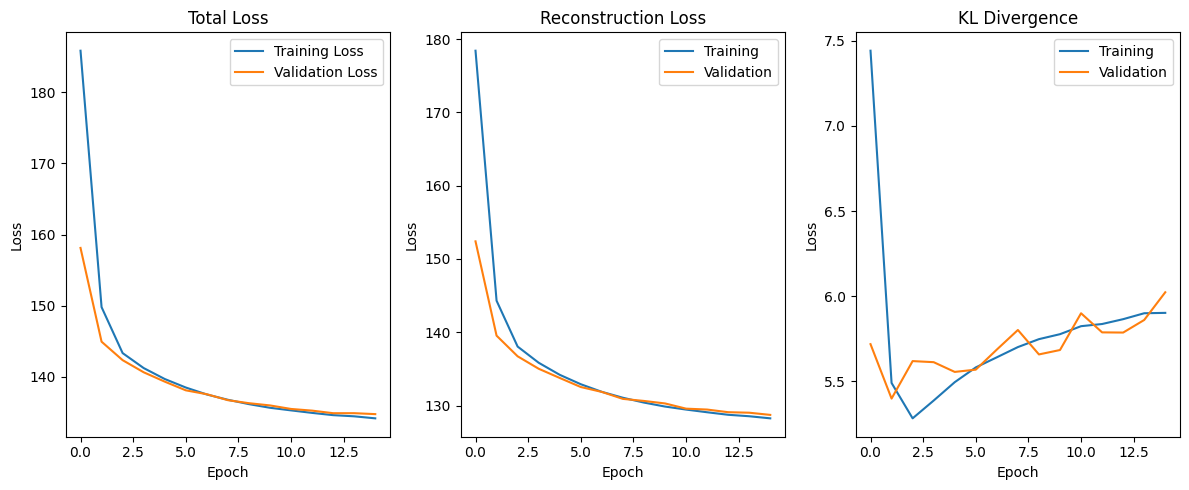

Saving model...
Model saved to models/vae_model.pth
Visualizing sample digits...


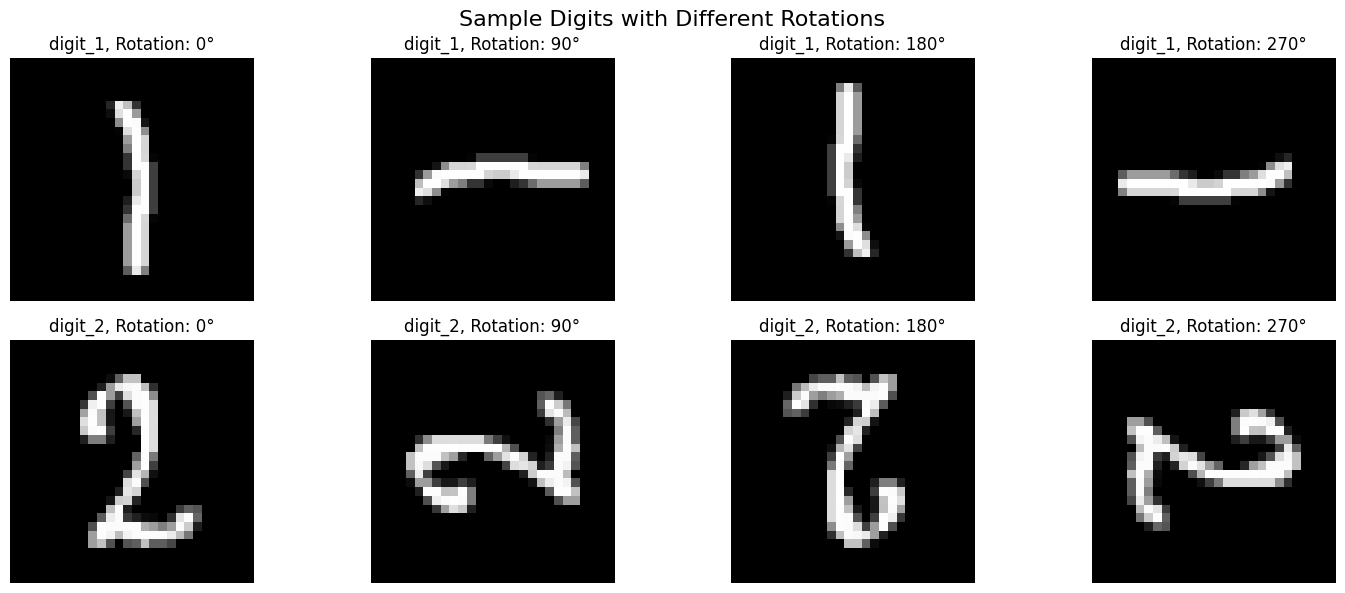

Visualizing latent space...


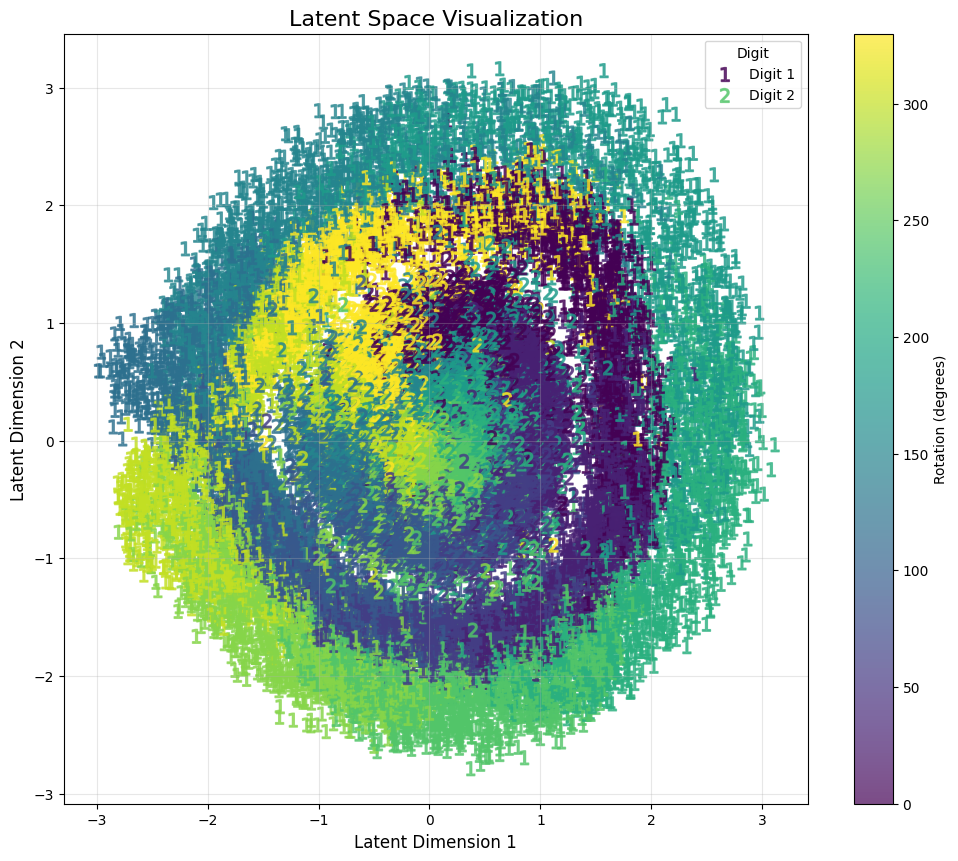

Plotting rotation trajectories...


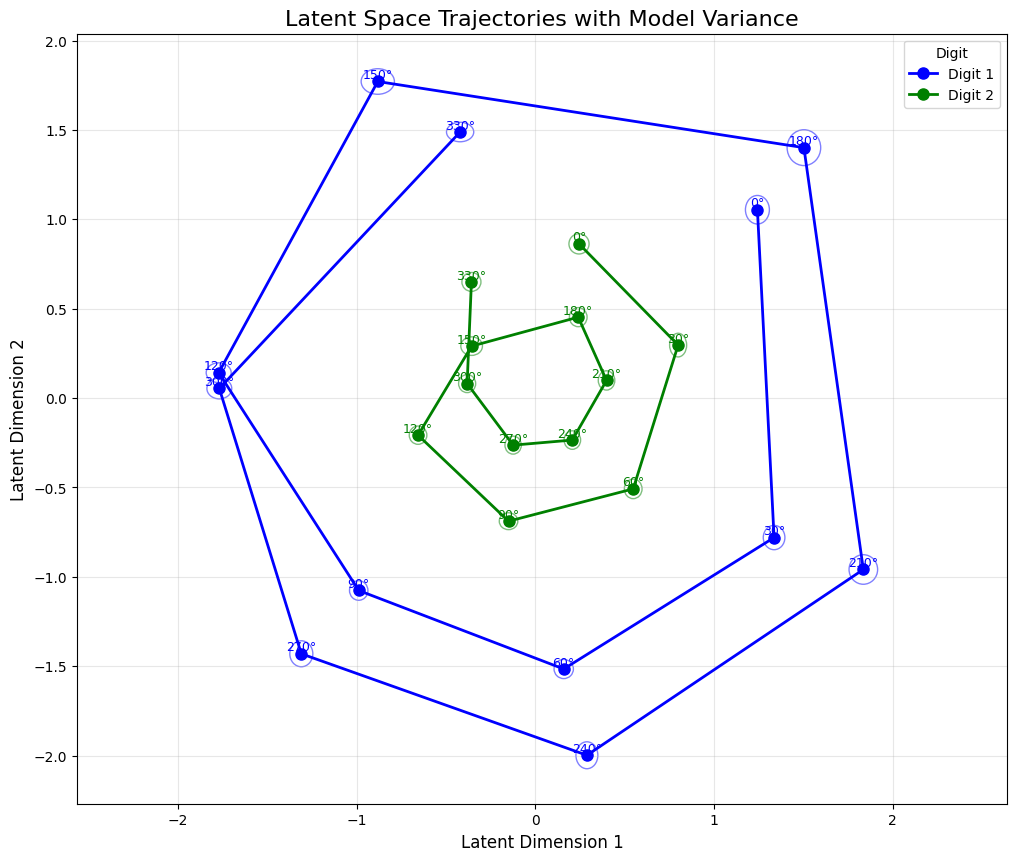

Visualizing reconstructions...


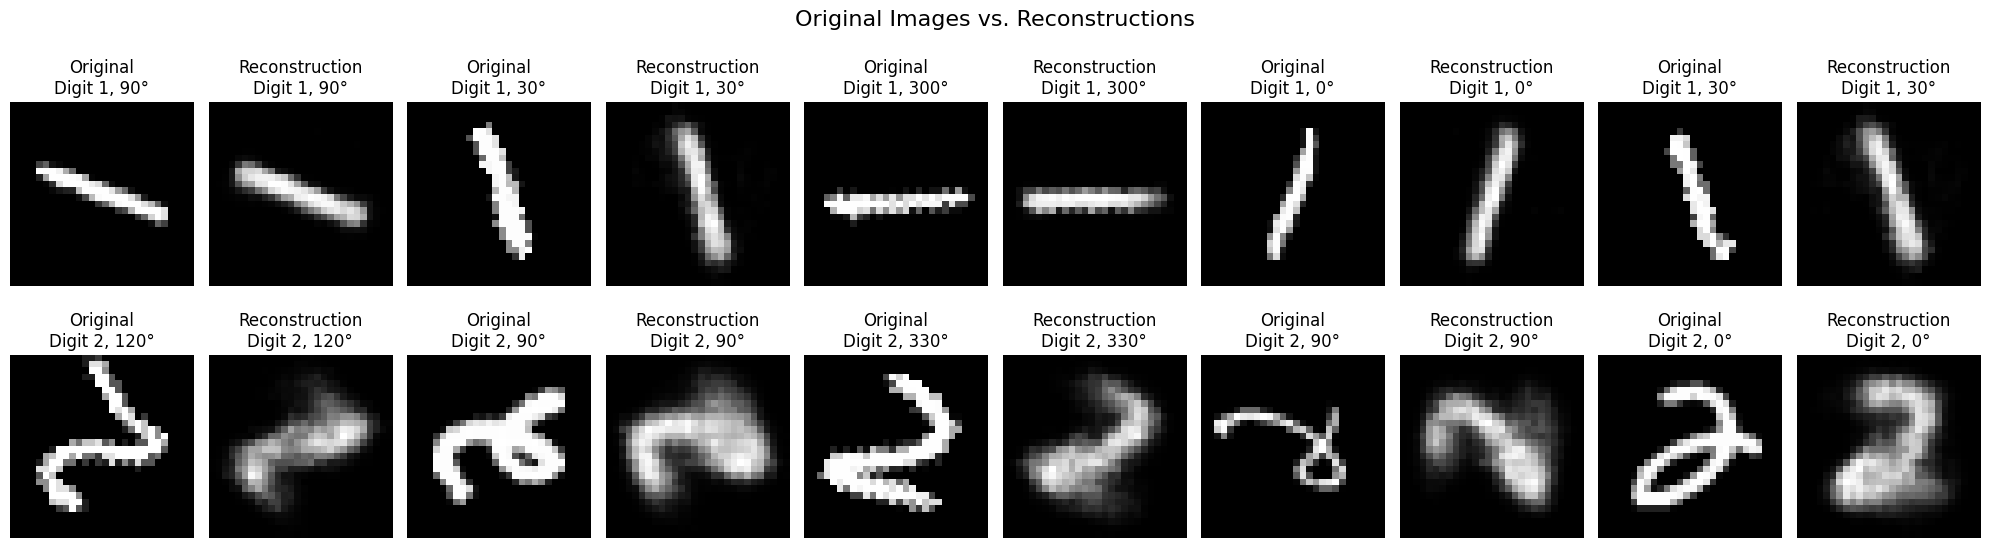

Generating from latent space...


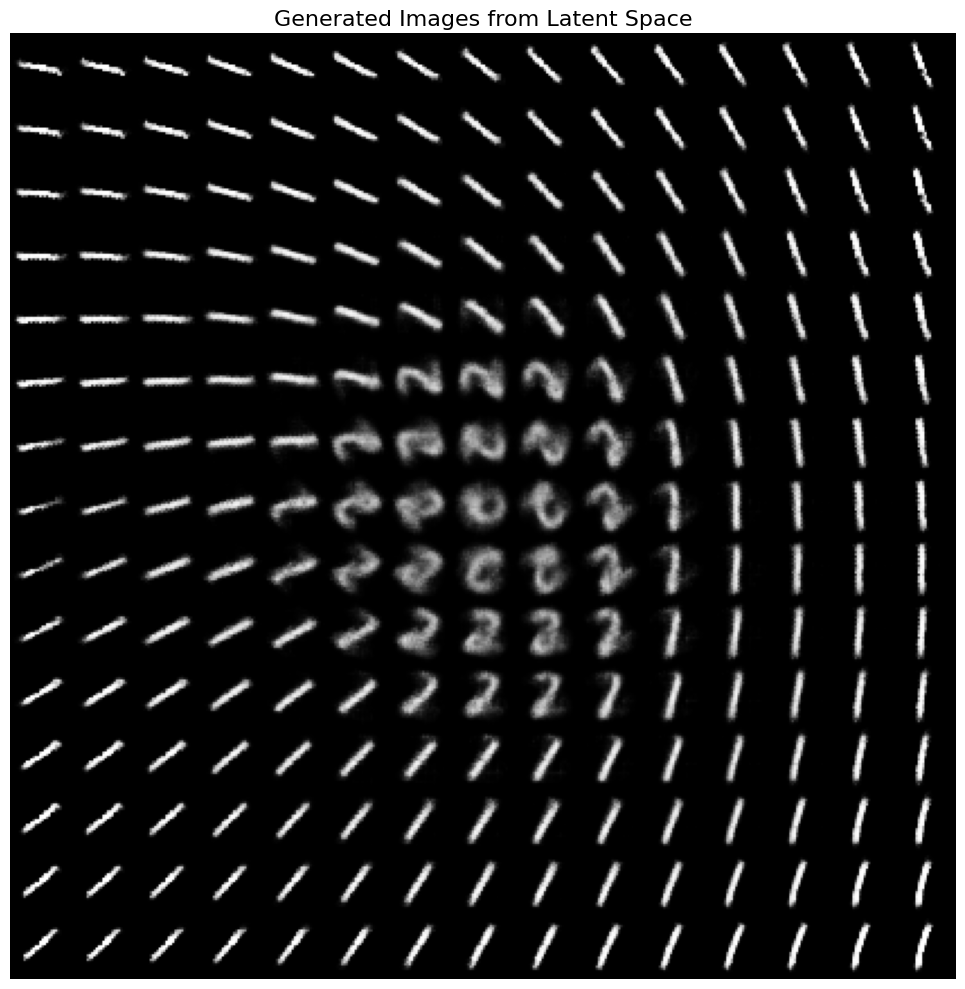

Analyzing rotation invariance...


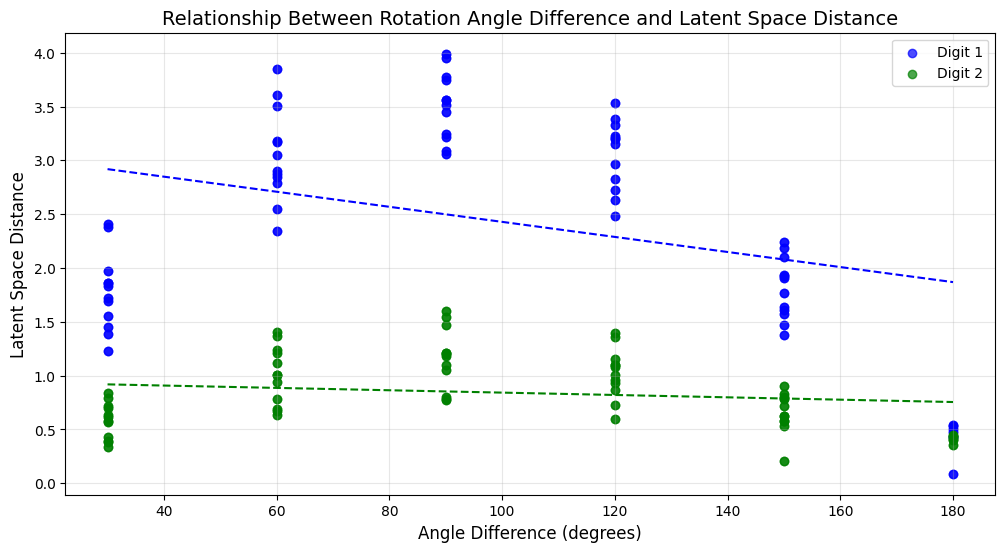

Plotting rotation sensitivity heatmap...


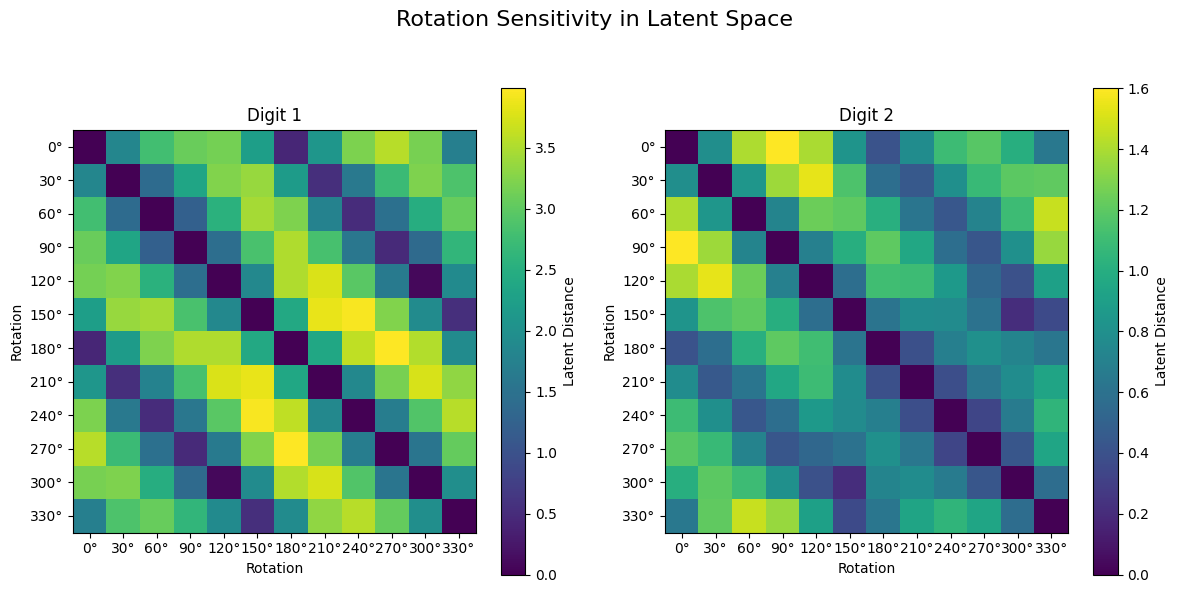

Interpolating in latent space...


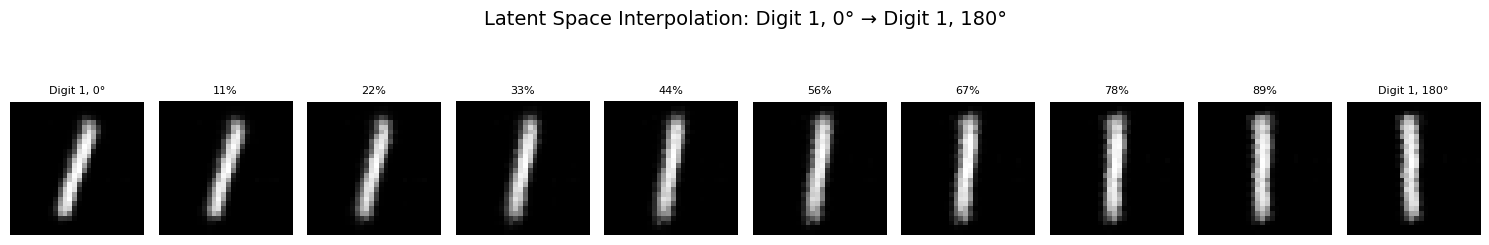

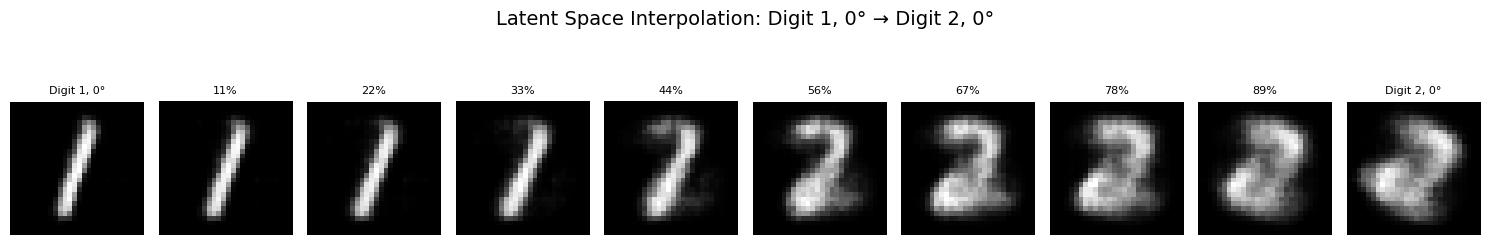

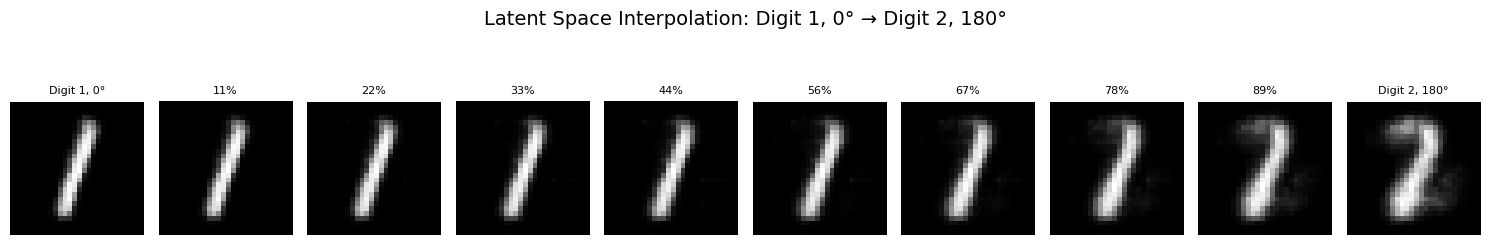

Analysis complete!


In [2]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual file path
    file_path = "/kaggle/input/e2e-specific-task-1-dataset/rotated_digits.hdf5"
    
    # Run the complete analysis pipeline
    model = run_mnist_rotations_analysis(
        file_path,
        digits=['digit_1','digit_2'],
        model_type="conv",  # or "deep" , "conv"
        latent_dim=2,
        batch_size=128,
        epochs=15,
        kld_weight=1.0,
        load_existing=False
    )